# Temporal model

In [51]:
# import relevant libraries

# General libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

import seaborn as sns

# sklearn and 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Personalized function library
from prepare_country_data import transpose_for_country_code, split_and_normalize, cyclical_transformation

# Numpyro libraries
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# JAX
import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 


## Import and prepare dataset

In [8]:
# Load complete dataset
df = pd.read_csv("data/2023/nordic_energy_data.csv")

df_dk1 = transpose_for_country_code(df, "DK_1")

# Apply cyclical transformation to time
df_dk1 = cyclical_transformation(df_dk1)
# Chose desired time period
df_dk1['Timestamp'] = pd.to_datetime(df_dk1['Timestamp'])
#df_dk1 = df_dk1[(df_dk1['Timestamp'].dt.month >= 11) & (df_dk1['Timestamp'].dt.month <= 12)]
test_days = 31
# Apply split and normalization based on desired number of test days
X_train, X_test, y_train, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std = split_and_normalize(df_dk1, test_days=test_days)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Convert to numpy arrays - relevant for some models
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()
y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()

# X_train.head()

X_train shape: (7992, 92)
X_test shape: (744, 92)
y_train shape: (7992,)
y_test shape: (744,)


## Simple Temporal model 

In [9]:
T = len(y_train)
T_forecast = len(y_test)

# Remove first two input values since we use an AR(2) model
x = pd.concat([X_train[2:], X_test]).to_numpy()
x = x[:,:5] # only use first 5 parameters 
y = y_train.to_numpy()

N,D = x.shape

ix_obs = np.arange(T)

y_true_std = y_train_std
y_true_mean = y_train_mean

print("T=%d" % T)
print("T_forecast=%d" % T_forecast)
print("N=%d, D=%d" % (N,D))



T=7992
T_forecast=744
N=8734, D=5


In [10]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    beta1, beta2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = beta1*h_prev1 + beta2*h_prev2 + jnp.matmul(W, x_t) + tau*noise_t
    h_prev2 = h_prev1
    h_prev1 = h_t
    
    return (beta1,beta2, W, h_prev1,h_prev2, tau), h_t

In [11]:
def model(T, T_forecast, x_t, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    beta1 = numpyro.sample("beta1", dist.Normal(loc=0., scale=1.))
    beta2 = numpyro.sample("beta2", dist.Normal(loc=0., scale=1.))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros(D), scale=jnp.ones(D)))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=.1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("z_1", dist.Normal(loc=0., scale=.1))
    h_prev2 = numpyro.sample("z_2", dist.Normal(loc=0., scale=.1))

    noises_t = numpyro.sample("noises_t", dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (beta1, beta2, W, h_prev1, h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    # Sample observed and missing values
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_mis", dist.Normal(loc=h_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_obs", dist.Normal(loc=h_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    numpyro.sample("y_pred", dist.Normal(loc=h_collection[T:], scale=sigma), obs=None)
    return h_collection

In [12]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
model = numpyro.jit(model)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, 
         x_t=x, obs=y, 
         ix_mis=None, ix_obs=ix_obs)


/var/folders/yv/5qf9yfms5h77gqr4g5tzmzzh0000gn/T/ipykernel_30293/1189035142.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [16:45<00:00,  1.99it/s, 1023 steps of size 4.54e-03. acc. prob=0.91]


In [13]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
            B1      1.29      0.01      1.29      1.27      1.31    136.06      1.03
            B2     -0.48      0.01     -0.48     -0.50     -0.46    160.51      1.03
          W[0]      0.02      0.00      0.02      0.01      0.03    349.58      1.00
          W[1]      0.18      0.01      0.18      0.16      0.20    288.58      1.00
          W[2]     -0.12      0.01     -0.12     -0.13     -0.11    298.71      1.00
          W[3]     -0.10      0.01     -0.10     -0.12     -0.09    385.47      1.00
          W[4]     -0.17      0.01     -0.17     -0.19     -0.16    220.46      1.00
          W[5]     -0.02      0.00     -0.02     -0.02     -0.01    352.66      1.01
          W[6]     -0.01      0.01     -0.01     -0.02     -0.00    259.36      1.00
          W[7]     -0.00      0.00     -0.00     -0.01      0.00    314.71      1.01
          W[8]      0.00      0.00      0.00     -0.00      0.01

In [14]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

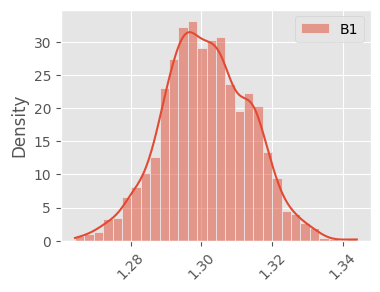

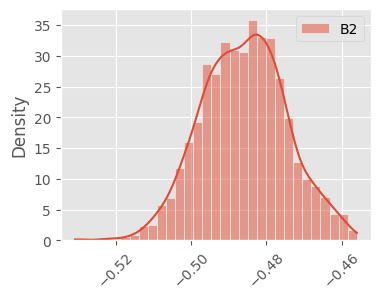

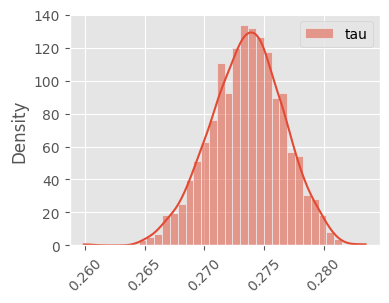

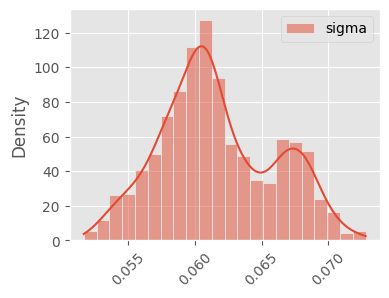

In [15]:
nodes = ["B1","B2", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(f"plots/{node}_histogram.png",bbox_inches='tight')
    plt.show()

In [16]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [17]:
predictions_temporal_MMCA = y_hat * y_true_std + y_true_mean

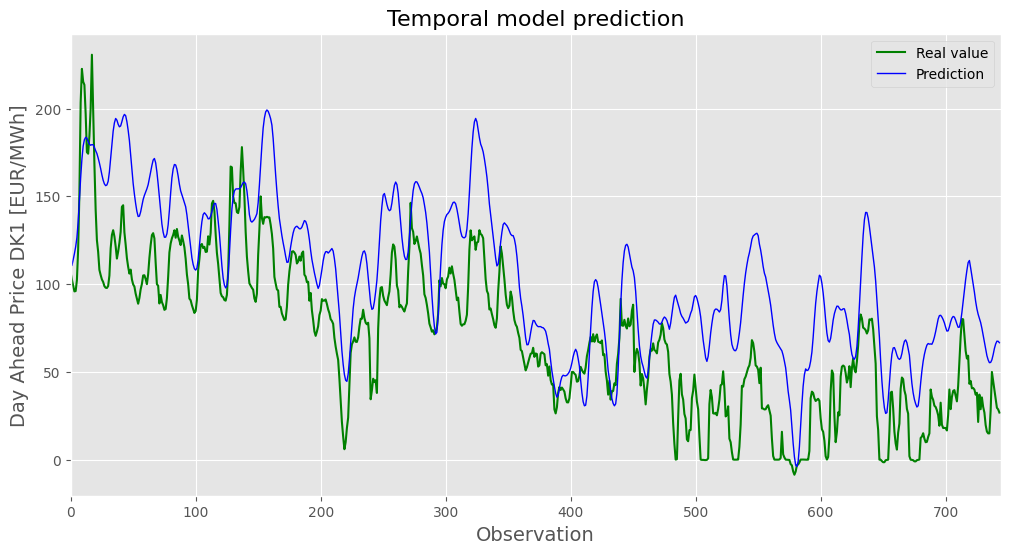

In [18]:
y_pred_true = (y_test.to_numpy() * y_true_std) + y_true_mean
y_hat = (y_hat * y_true_std) + y_true_mean

plt.figure(figsize=(12,6))
plt.plot(np.arange(T_forecast), y_pred_true, color = 'green')
plt.plot(np.arange(T_forecast), y_hat, color = 'blue', linewidth=1)
plt.xlabel("Observation", fontsize=14)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=14)
plt.xlim([0, T_forecast])
plt.legend(["Real value", "Prediction"])
plt.title("Temporal model prediction", fontsize=16)
# plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
plt.show()


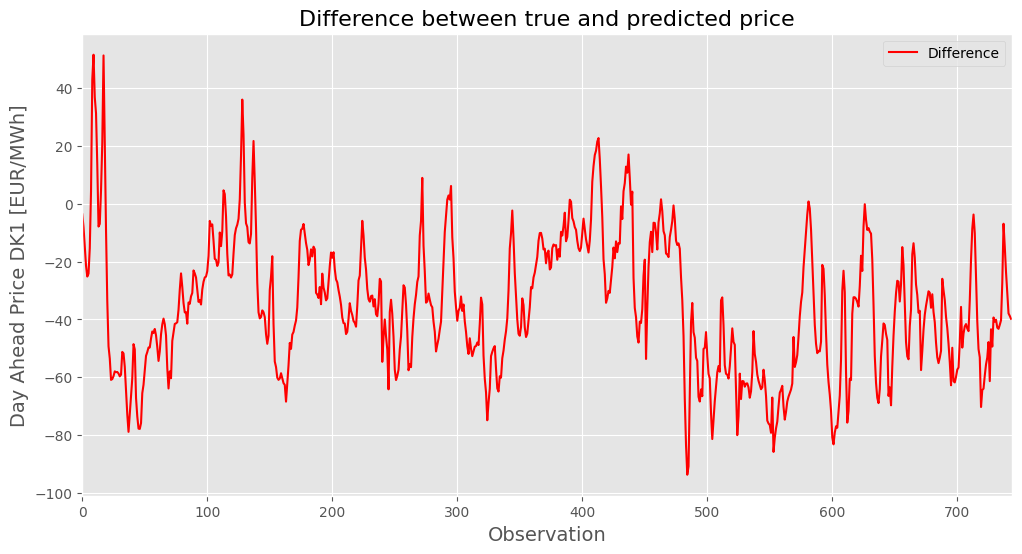

In [19]:
y_diff = y_pred_true - y_hat
plt.figure(figsize=(12,6))
plt.plot(np.arange(T_forecast), y_diff, color = 'red')
plt.xlabel("Observation", fontsize=14)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=14)
plt.xlim([0, T_forecast])
plt.legend(["Difference"])
plt.title("Difference between true and predicted price", fontsize=16)
# plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
plt.show()

In [20]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [21]:
corr, mae, rae, rmse, r2 = compute_error(y_pred_true, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f" % (corr, mae, rmse))

CorrCoef: 0.857
MAE: 36.95695
RMSE: 42.23582


# Multivariate LDS with input

In [43]:
df = pd.read_csv("data/2023/nordic_energy_data.csv")

uniqueBiddingZones = df['country_code'].unique()
#print(uniqueBiddingZones)

# Create new dataframe with only timestamp
df_new = transpose_for_country_code(df, 'DK_1')
df_new = df_new["Timestamp"]
price = df_new

# Drop column "Unnamed: 0"
df = df.drop(columns=['Unnamed: 0', 'Actual Load'])
df = df.loc[:,(~df.columns.str.contains("Ex") & ~df.columns.str.contains("Imp"))]
df = df.loc[:,(~df.columns.str.contains("Cap"))]
df = df.rename(columns={'DA-price [EUR/MWh]': 'Price'})

biddingZone = 'DK_1'

for biddingZone in uniqueBiddingZones[:2]:
    df_country = df[df['country_code'] == biddingZone]
    # Make NaN values = 0
    df_country = df_country.fillna(0)
    # Drop columns that are all 0
    df_country = df_country.loc[:, (df_country != 0).any(axis=0)]
    # Drop columns where the valye for all rows are the same
    df_country = df_country.loc[:, df_country.nunique() != 1]
    # Add suffix to columns indicating country code
    excludeCol = 'Timestamp'
    suffix = '_%s' % biddingZone
    newColNames = {col: f"{col}{suffix}" for col in df_country.columns if col != excludeCol}
    df_country = df_country.rename(columns = newColNames)

    price = pd.merge(price, df_country.iloc[:, :2], on='Timestamp', how='left')

    df_country = df_country.drop(columns=['Price%s' % suffix])
    df_new = pd.merge(df_new, df_country, on='Timestamp', how='left')

df_new = df_new.loc[:, df_new.nunique() != 1]

df_new["Timestamp"] = pd.to_datetime(df_new["Timestamp"])
df_new.set_index("Timestamp", inplace=True)
price["Timestamp"] = pd.to_datetime(price["Timestamp"])
price.set_index("Timestamp", inplace=True)

df_new.head()

,Forecasted Load_DK_1,Forecasted Generation_DK_1,Solar_DK_1,Wind Offshore_DK_1,Wind Onshore_DK_1,Forecasted Load_DK_2,Forecasted Generation_DK_2,Solar_DK_2,Wind Offshore_DK_2,Wind Onshore_DK_2,Hour_sin,Hour_cos,Day_sin,Day_cos
Timestamp,,,,,,,,,,,,,,
2023-01-01 00:00:00,2135.0,832.0,0.0,75.0,556.0,1279.0,1360.0,0.0,319.0,423.0,0.000000,1.000000,0.781831,0.62349
2023-01-01 01:00:00,2084.0,974.0,0.0,146.0,639.0,1243.0,1340.0,0.0,331.0,469.0,0.258819,0.965926,0.781831,0.62349
2023-01-01 02:00:00,2059.0,1165.0,0.0,328.0,735.0,1230.0,1178.0,0.0,324.0,502.0,0.500000,0.866025,0.781831,0.62349
2023-01-01 03:00:00,2001.0,1437.0,0.0,376.0,870.0,1172.0,1207.0,0.0,319.0,522.0,0.707107,0.707107,0.781831,0.62349
2023-01-01 04:00:00,1969.0,1517.0,0.0,429.0,1047.0,1126.0,1154.0,0.0,327.0,529.0,0.866025,0.500000,0.781831,0.62349


In [44]:
# Limit data used
df_new = df_new.iloc[:100*24,:]
price = price.iloc[:100*24,:]

# Split and normalize data
test_days = 31

len_df = len(df_new)
test_size = (test_days * 24) / len_df

X_train, X_test, y_train, y_test = train_test_split(df_new, price, test_size=test_size, shuffle=False)

# Normalize the data based on the training set
x_train_mean = X_train.mean()
x_train_std = X_train.std()
y_train_mean = y_train.mean()
y_train_std = y_train.std()

# Normalize the data based on the training set
X_train = (X_train - x_train_mean) / x_train_std
X_test = (X_test - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

# make NaN and Inf 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)
# drop columns that are all 0
X_train = X_train.loc[:, (X_train != 0).any(axis=0)]
X_test = X_test.loc[:, (X_test != 0).any(axis=0)]

In [45]:
T = len(y_train)
T_forecast = len(y_test)

# Remove first two input values since we use an AR(2) model
x = pd.concat([X_train[2:], X_test]).to_numpy()
x = x[:,:5] # only use first 5 parameters 
y = y_train.to_numpy()

N,D = x.shape
M = y.shape[1]

ix_obs = np.arange(T)

y_true_std = y_train_std
y_true_mean = y_train_mean

print("T=%d" % T)
print("T_forecast=%d" % T_forecast)
print("N=%d, D=%d" % (N,D))
print("M=%d" % M)

T=1656
T_forecast=744
N=2398, D=14
M=2


In [46]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    B1, B2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = jnp.matmul(B1,h_prev1) + jnp.matmul(B2,h_prev2) + jnp.matmul(W, x_t) + tau*noise_t
    h_prev2 = h_prev1
    h_prev1 = h_t
    
    return (B1,B2, W, h_prev1,h_prev2, tau), h_t

In [46]:
def model(T, T_forecast, x_t, obs=None):
    # Define priors over B, R, W, c
    B1 = numpyro.sample("B1", dist.Normal(loc=jnp.zeros((M,M)), scale=jnp.ones((M,M))))
    B2 = numpyro.sample("B2", dist.Normal(loc=jnp.zeros((M,M)), scale=jnp.ones((M,M))))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros((M,D)), scale=jnp.ones((M,D))))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=0.1 * jnp.ones(M)))

    # Ensure tau has no negative values
    #tau = jnp.clip(tau, a_min=1e-6, a_max=None)

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("h_prev1", dist.Normal(loc=jnp.zeros(M), scale=0.1 * jnp.ones(M)))
    h_prev2 = numpyro.sample("h_prev2", dist.Normal(loc=jnp.zeros(M), scale=0.1 * jnp.ones(M)))

    # LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(M, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega)
    noises_t = numpyro.sample("noises_t", dist.MultivariateNormal(loc=jnp.zeros(M), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (B1, B2, W, h_prev1, h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    R = sigma*jnp.eye(M)

    # Sample observed and missing values
    numpyro.sample("y_obs", dist.MultivariateNormal(loc=h_collection[:T], covariance_matrix=R), obs=obs)
    if T_forecast>0:
        numpyro.sample("y_pred", dist.MultivariateNormal(loc=h_collection[T:], covariance_matrix=R), obs=None)
    return h_collection

In [52]:
t_start = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=2)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, 
         x_t=x, obs=y)

/var/folders/yv/5qf9yfms5h77gqr4g5tzmzzh0000gn/T/ipykernel_29410/3989324132.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=2)
sample: 100%|██████████| 1500/1500 [25:46<00:00,  1.03s/it, 1023 steps of size 7.28e-04. acc. prob=0.93]   


In [ ]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
           B1[0,0]      0.38      0.97      0.47     -0.71      1.40      1.01     13.33
           B1[0,1]      0.57      0.69      0.47     -0.18      1.38      1.01     11.45
           B1[1,0]     -0.71      0.69     -0.60     -1.50      0.06      1.01      9.87
           B1[1,1]      1.76      0.53      1.70      1.17      2.37      1.01      8.75
           B2[0,0]     -0.33      0.24     -0.39     -0.62      0.03      1.09      4.57
           B2[0,1]     -0.05      0.19      0.03     -0.37      0.16      1.40      3.07
           B2[1,0]      0.07      0.17      0.01     -0.15      0.31      1.20      2.66
           B2[1,1]     -0.46      0.16     -0.40     -0.73     -0.26      1.53      2.31
      L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
      L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
      L_Omega[1,0]  

In [58]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

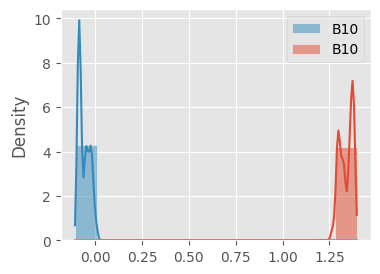

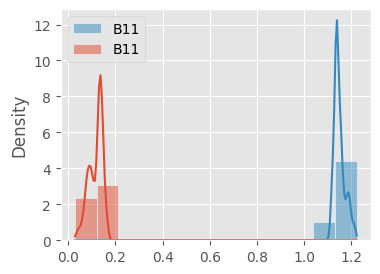

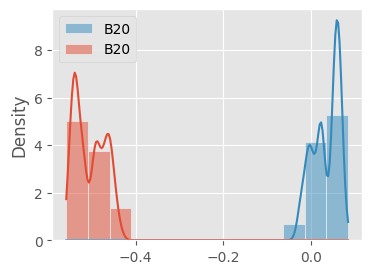

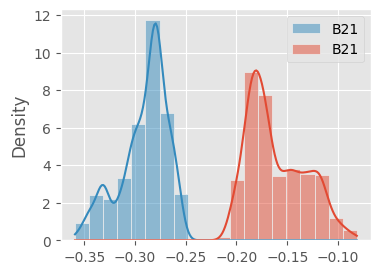

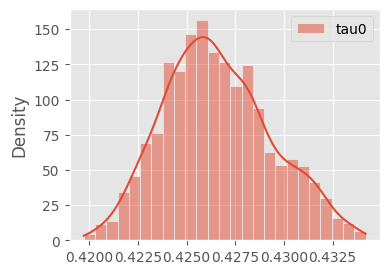

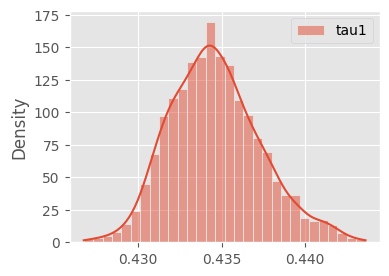

In [59]:
nodes = ["B1", "B2", "tau"]
for node in nodes:
  if node in ("B1", "B2", "tau"):
    for i in range(M):
      plt.figure(figsize=(4,3))
      sns.histplot(hmc_samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()

In [60]:
y_hat = hmc_samples["y_pred_DK_1"].mean(axis=0)
y_std = hmc_samples["y_pred_DK_1"].std(axis=0)
y_pred_true = (y_test.to_numpy() * y_true_std.to_numpy()) + y_true_mean.to_numpy()
y_hat = (y_hat * y_true_std.to_numpy()) + y_true_mean.to_numpy()

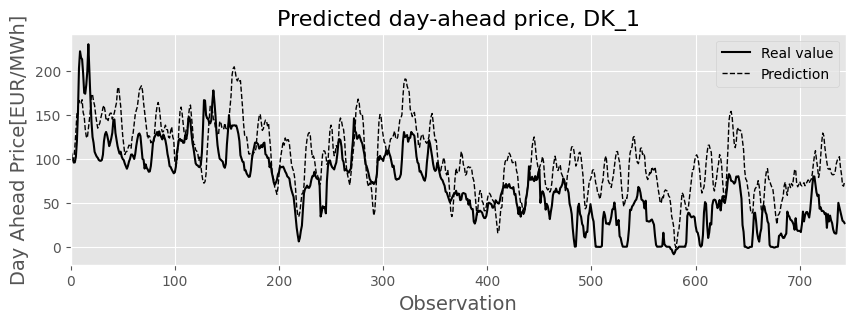

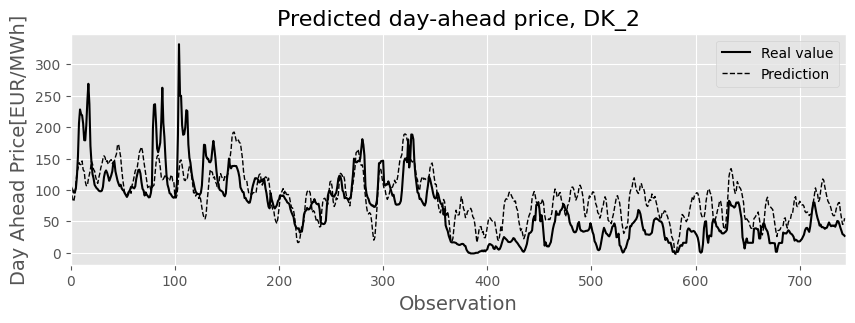

In [62]:
#y_pred_true = (y_test.to_numpy() * y_true_std) + y_true_mean
#y_hat = (y_hat * y_true_std) + y_true_mean

for ii in np.arange(y_hat.shape[1]):
    plt.figure(figsize=(10,3))
    plt.plot(np.arange(T_forecast), y_pred_true[:, ii], color = 'black')
    plt.plot(np.arange(T_forecast), y_hat[:, ii], color = 'black', linestyle='--', linewidth=1)
    plt.xlabel("Observation", fontsize=14)
    plt.ylabel("Day Ahead Price[EUR/MWh]", fontsize=14)
    plt.xlim([0, T_forecast])
    plt.legend(["Real value", "Prediction"])
    plt.title("Predicted day-ahead price, %s" % uniqueBiddingZones[ii], fontsize=16)
    # plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
    plt.show()

[  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336 360 384 408
 432 456 480 504 528 552 576 600 624 648 672 696 720]


NameError: name 'predictions_temporal_MMCA' is not defined

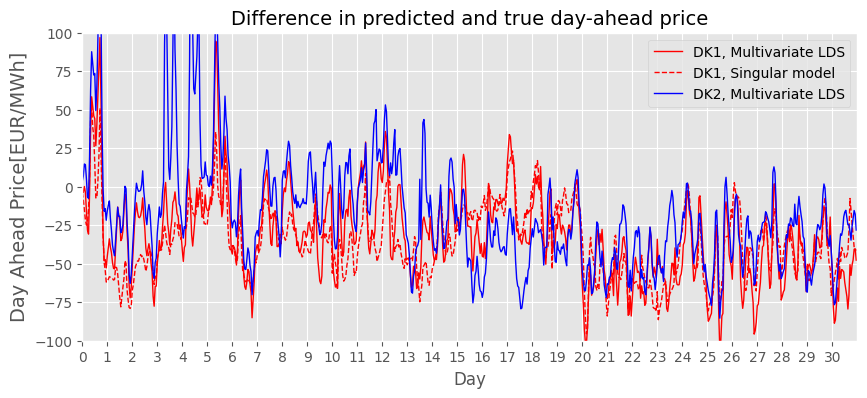

In [91]:
y_difference = y_pred_true - y_hat

ticks = np.arange(test_days) * 24 
print(ticks)

plt.figure(figsize=(10,4))
plt.plot(np.arange(T_forecast), y_difference[:, 0], color='red', linewidth=1)
plt.plot(np.arange(T_forecast), y_pred_true[:, 0] - predictions_temporal_MMCA, color='red', linestyle='--', linewidth=1)
plt.plot(np.arange(T_forecast), y_difference[:, 1], linewidth=1, color='blue')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Day Ahead Price[EUR/MWh]", fontsize=14)
plt.xlim([0, T_forecast])
plt.ylim([-100, 100])
plt.xticks(ticks, np.arange(test_days))
plt.legend(["DK1, Multivariate LDS", "DK1, Singular model", "DK2, Multivariate LDS"])
plt.title("Difference in predicted and true day-ahead price", fontsize=14)
# plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
plt.show()